##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [98]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from multiprocessing import Pool
from functools import partial
from sklearn import metrics

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats

from ipywidgets import FloatProgress, HTML
from IPython.display import display, clear_output
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

import json


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['PPFD_Avg','AirTC_Avg','VPD','wind_speed',
                    'Temp','VWC','Sedge','Shrub','Grass','Upland',
                    'HR','DOY']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VPD','wind_speed','VWC']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model=['AirTC_Avg','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1','VWC_1','Delta_VWC_1',
                   'VWC_2','Delta_VWC_2','Temp_2_5_1','Temp_5_1','Temp_15_1','Active_Layer_1',
                   'u*','wind_speed']#,'air_pressure','Delta_air_pressure']
        if Scope == 'Test':
            Model=['H','AirTC_Avg','RH_Samp','VPD','NR_Wm2_Avg','PPFD_Avg','Table_1','Delta_Table_1',
            'VWC_2','VWC_1','Temp_2_5_1','Temp_5_1','Temp_15_1','Delta_Temp_1',
            'Active_Layer_1','u*','wind_speed','air_pressure']
    return(Model)

def Stats(mse,se,r2,j,params,i=0):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],'MSE':[mse],'Size':j,'Number':i,'HiddenNodes':params['N'],
                            'SE':[se],'r2':[r2],'Performance':0,'K':[params['K']]})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))
MP = False
MP = True
Scope = 'Full'
# Scope = 'Test'
if MP == True:
    processes = 3
else:
    processes = 1
# memory = .95/processes
    
cwd = os.getcwd()
Site='FishIsland'
# Site = 'Illisarvik'
alpha = .05

pd.set_option('max_colwidth',200)
def Display (tar,prog1=None,prog2=None,MdLs=None,MdL=None):
    clear_output()
    display(tar)
    if prog1!=None:
        display(prog1)
    if prog2!=None:
        display(prog2)
    if MdLs!=None:
        display(MdLs)
    if MdL!=None:
        display(MdL)
    
tar = HTML(
            value=" ",
            placeholder='Target: ',
            description='Target: ',
        )
kwt = HTML(
        value=str(0),
        placeholder='Quit Score: ',
        description='Quit Score: ',
        )

# Model

In [99]:
# depth = 15
Time = time.time()
AllRes={}
if __name__ == '__main__':
    for target in ['fch4','fco2']:
        AllRes[target]={}
        AllRes[target]['Results'] = {}
        AllRes[target]['Derivatives'] = {}
        AllRes[target]['SSQ'] ={}
        AllRes[target]['X'] = {}
        AllRes[target]['Y_hat'] = {}
        AllRes[target]['Y_true'] = {}
        AllRes[target]['Outputs'] = {}
        AllRes[target]['Factors'] = []
        Rm = []
        Input=ModSelect(Scope,Site)
        start = len(Input)
        IpKey=np.arange(0,start)
        IpDict={'Factors':Input.copy(),'Key':IpKey}
        try:shutil.rmtree(cwd+'/'+Site+'/'+target+'/')
        except:pass
        os.mkdir(cwd+'/'+Site+'/'+target+'/')  
        tar.value=target
        prog2 = FloatProgress(min=0, max=100,description='Bootstrapping:')
        MdL = HTML(value=" ",placeholder='Testing: ',description='Testing: ')
        Display (tar,prog2=prog2,MdL=MdL)
        Continue = True
        first = 1
        num = 0
#         for Input in Models:
        while Continue == True:
            Time2 = time.time()
            j = len(Input)
            params = Dense.Params(Scope,target,MP=MP)
            params['Dpath'] = cwd+'/'+Site+'/'
            params['Spath'] = params['Dpath']+target+'/'+str(j)+'_'+str(num)+'/'
            try:os.mkdir(params['Spath'])
            except:pass
            params['Sname'] = 'Y_'
            params['Inputs'] = Input
            MdL.value='N = '+str(j)+':  '+str(params['Inputs'])
            Display (tar,prog2=prog2,MdL=MdL)
            print('Total Runtime: ',time.time()-Time)
            print('Training Time: ', time.time()-Time2)
            params['Model'] = '+'.join(params['Inputs'])
            RST = RSTF.ReadStandardTimeFill(params,'AllData.csv')#,resample='2H')
            if target == 'ER':
                RST.Master = RST.Master.loc[RST.Master['fco2']>0]
            RST.Scale(params['target'],params['Inputs']) 
            y = RST.y*1.0
            X = RST.X*1.0
            Ni = len(Input)
            Ns = y.shape[0]
            No = 1
            a = 2
            params['N']=int(Ns/(a*(Ni+No)))
            # Rule by Maier et al. 1998
#             A = int(2*Ni+No)
#             B = int(2*Ns/((Ni+No)))
#             if A<B:params['N']=A
#             else:params['N']=B
                
            params['Memory'] = (math.floor(100/params['proc'])- 5/params['proc']) * .01
            Y_hat=[]
            y_true=[]
            X_true=[]
            index=[]
            ones=[]
            prog2.value=0
            Avs = []
            Derivatives = []
            Outputs=[]
            if MP == False:
                for k in range(params['K']):
                    results = Dense.Bootstrap(k,params=params,X=X,y=y)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs = results[6]
            else:
                pool = Pool(processes=processes,maxtasksperchild=75)
                for k,results in enumerate(pool.imap_unordered(partial(Dense.Bootstrap,params=params,X=X,y=y),range(params['K']))):
#                     print(k)
                    Y_hat.append(RST.YScaled.inverse_transform(results[0]))
                    y_true.append(RST.YScaled.inverse_transform(results[1]))
                    X_true.append(RST.XScaled.inverse_transform(results[2]))
                    ones.append(results[3])
                    prog2.value=(k+1)/params['K']*100
                    Avs.append(results[4])
                    Derivatives.append(results[5])
                    Outputs.append(results[6])
                pool.close()
            Y_hat = np.squeeze(np.asanyarray(Y_hat))
            y_true = np.squeeze(np.asanyarray(y_true))
            X_true = np.asanyarray(X_true)
            ones = np.asanyarray(ones)
            params['Memory'] = .95
            results = Dense.Sort_outputs(0,params=params,Y_hat=Y_hat,y_true=y_true,X_true=X_true,ones=ones)
            mse,se,r2 = results
            Level = Stats(mse,se,r2,j,params,i=num)
            Level.to_csv('Temp.csv')
#             prog1.value=start-j#+i/len(Inputs)
            Level['Thresh'] = Level['MSE']+Level['SE']
            Min = Level.loc[Level['MSE']==Level['MSE'].min()]
            if first == 1:
                Records = Level
            else:
                Records = Records.append(Level)
            Av = np.array(Avs).mean(axis=0)
            Drv = np.array(Derivatives)#.mean(axis=0)
            Av = (Drv.mean(axis=0)**2).sum(axis=1)
            SE = (np.array(Avs).T/np.array(Avs).sum(axis=1)).T
            SE = SE.std(axis=0)**.5/(params['K']**.5)
            if first==2:
                IpDict['RC: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
                IpDict['SE: '+str(j) +'_'+ str(num)]=np.zeros(Results.shape[0])#Av/Av.sum()
            else:
                first = 2
            Results = pd.DataFrame(data=IpDict)
            for I,A,S in zip(Input,Av,SE):
                Results.loc[Results['Factors']==I,'RC: '+str(j)+'_'+ str(num)]=A
                Results.loc[Results['Factors']==I,'SE: '+str(j)+'_'+ str(num)]=S
            Results['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)]/Results['RC: '+str(j)+'_'+ str(num)].sum()
            IpDict['RC: '+str(j)+'_'+ str(num)]=Results['RC: '+str(j)+'_'+ str(num)].values
            IpDict['SE: '+str(j)+'_'+ str(num)]=Results['SE: '+str(j)+'_'+ str(num)].values
            Results = Results.sort_values('RC: '+str(j)+'_'+ str(num))
            Rm.append(Results.Factors.values[num])
            print(Rm,Results.Factors.values[num])
            Input.remove(Rm[-1])
            Results = Results.sort_values('Key')
            Min = Records.loc[Records['MSE']==Records['MSE'].min()]
            if Min['MSE'].values[0]+Min['SE'].values[0]<=Level['MSE'].values[0]:
#             if num > 2:
                Continue = False
            AllRes[target]['Records']=Records
            AllRes[target]['Results'] = Results
            AllRes[target]['Derivatives'][j]=Drv
            AllRes[target]['SSQ'][j]=Avs
            AllRes[target]['X'][j] = X_true[0]
            AllRes[target]['Outputs'][j] = Outputs
            AllRes[target]['Y_hat'][j] = Y_hat
            AllRes[target]['Y_true'][j] = y_true
            AllRes[target]['Factors'].append(j)
            AllRes[target]['Removed']=Rm
            Records.to_csv('C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'+target+'_Runs.csv')
            num +=1
#             with open(target+'dict.txt','w') as file:
#                 file.write(json.dumps(AllRes))
#             j+=1

HTML(value='fco2', description='Target: ', placeholder='Target: ')

FloatProgress(value=100.0, description='Bootstrapping:')

HTML(value="N = 6:  ['VPD', 'PPFD_Avg', 'Temp_2_5_1', 'Temp_5_1', 'Active_Layer_1', 'u*']", description='Testi…

Total Runtime:  7596.987368345261
Training Time:  0.0438847541809082
['Table_1', 'Delta_VWC_2', 'AirTC_Avg', 'VWC_1', 'VWC_2', 'Temp_15_1', 'NR_Wm2_Avg', 'Delta_Table_1', 'Delta_VWC_1', 'wind_speed', 'u*'] u*


In [ ]:
def RecWrite(AllRes):
    for f in AllRes.keys():
# from keras.models import model_from_json
# with open(params['Spath']+'Y_'+'.json', 'r') as json_file:
#     loaded_model = model_from_json(json_file.read())
#     print(params['Spath'])

<IPython.core.display.Javascript object>


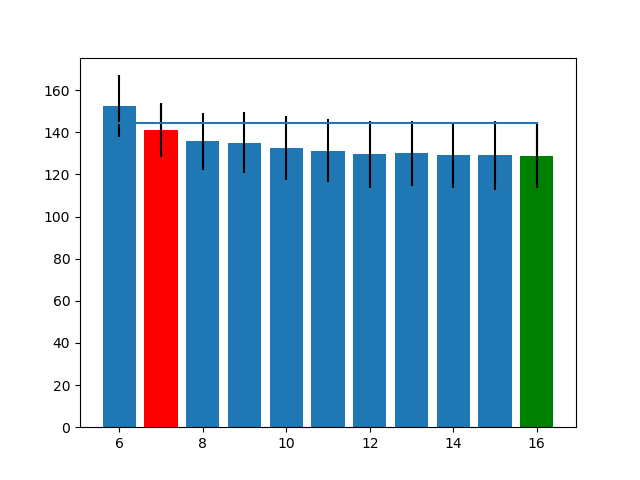

                                                                                                                                                       Model  \
16_0  AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+Delta_Table_1+VWC_1+Delta_VWC_1+VWC_2+Delta_VWC_2+Temp_2_5_1+Temp_5_1+Temp_15_1+Active_Layer_1+u*+wind_speed   
15_1        AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+Delta_Table_1+Delta_VWC_1+VWC_2+Delta_VWC_2+Temp_2_5_1+Temp_5_1+Temp_15_1+Active_Layer_1+u*+wind_speed   
14_2                 AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+Delta_Table_1+Delta_VWC_1+VWC_2+Delta_VWC_2+Temp_2_5_1+Temp_15_1+Active_Layer_1+u*+wind_speed   
13_3                             AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+Delta_Table_1+VWC_2+Delta_VWC_2+Temp_2_5_1+Temp_15_1+Active_Layer_1+u*+wind_speed   
12_4                                      AirTC_Avg+VPD+NR_Wm2_Avg+Table_1+Delta_Table_1+VWC_2+Delta_VWC_2+Temp_2_5_1+Temp_15_1+Active_Layer_1+u*+wind_speed   
11_5                                    

In [115]:
F = 'fch4'
Results = AllRes[F]['Results']

AllRes[F]['Records']['RMSE']=(AllRes[F]['Records']['MSE']**.5)
Records = AllRes[F]['Records']
# print(Records)

plt.figure()
Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]]
Best = Best.loc[Best['Size']==Best['Size'].min()]
plt.bar(Records['Size'],Records['MSE'],yerr=Records['SE'])
plt.bar(Best['Size'],Best['MSE'],yerr=Best['SE'],color='r')
plt.bar(Min['Size'],Min['MSE'],yerr=Min['SE'],color='g')
line = [Min['MSE'].values[0]+Min['SE'].values[0],Min['MSE'].values[0]+Min['SE'].values[0]]
plt.plot([Records['Size'].min(),Records['Size'].max()],line)

a = 'RC: '+Best.index.values[0]
ase = 'SE: '+Best.index.values[0]
N = Best.Size.values[0]
Derivatives = AllRes[F]['Derivatives'][N]
Mean = Derivatives.mean(axis=0)
X = AllRes[F]['X'][N]
# print(Best)
print(Records)

{'Table_1': 0, 'Delta_Table_1': 1, 'VWC_2': 2, 'Temp_2_5_1': 3, 'Temp_15_1': 4, 'u*': 5, 'wind_speed': 6}


<IPython.core.display.Javascript object>


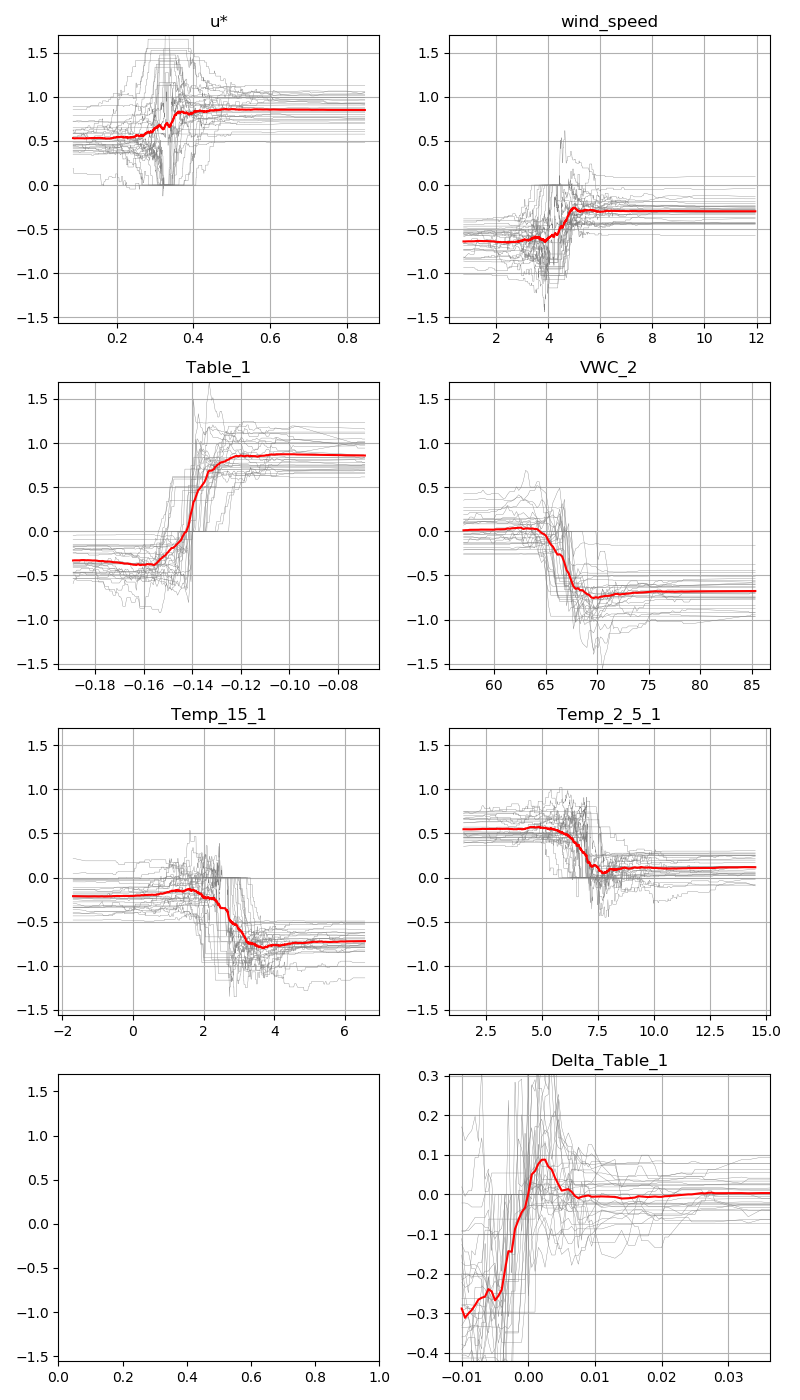

   index        Factors  Key  RC: 16_0  SE: 16_0  RC: 15_1  SE: 15_1  \
0     14             u*   14  0.384883  0.052617  0.376374  0.056673   
1      4        Table_1    4  0.049405  0.029860  0.054199  0.038276   
2     12      Temp_15_1   12  0.046632  0.033874  0.055650  0.043772   
3     15     wind_speed   15  0.203596  0.045730  0.197288  0.046770   
4      8          VWC_2    8  0.028944  0.031626  0.026309  0.025892   
5     10     Temp_2_5_1   10  0.090720  0.042469  0.110913  0.036483   
6      5  Delta_Table_1    5  0.050276  0.043471  0.040158  0.046645   

   RC: 14_2  SE: 14_2  RC: 13_3  ...  RC: 10_6  SE: 10_6   RC: 9_7   SE: 9_7  \
0  0.322825  0.057729  0.406449  ...  0.292623  0.058758  0.236844  0.054207   
1  0.054735  0.033547  0.063428  ...  0.092696  0.046224  0.150189  0.045693   
2  0.095128  0.041247  0.059003  ...  0.131322  0.048043  0.195493  0.047144   
3  0.202441  0.046802  0.163940  ...  0.191838  0.051780  0.126954  0.044407   
4  0.030018  0.026953  

In [116]:
Model = {}
for v,i in enumerate(Best.Model.values[0].split('+')):
    Model[i]=v
print(Model)
# N=3
fig,ax = plt.subplots(int((N+1)/2),2,figsize = (8,N*2))
# fig,ax = plt.subplots(1,figsize = (8,6))
# N=2
k = 0
j=0
TD = []
i = 0
mx,mn=-1,1
PD = {}
# plot = 'Table_1'
# a
if F == 'fch4':
    m,s = 35.12151605224374, 17.14604140914441
else:
    m,s = -0.4951036661457009, 0.9087660033468629


try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=False).reset_index()
except:
    pass
   
print(Results)
    
for f,r in zip(Results.Factors.values,Results[a].values):
#     print(f,r)
    ip = Model[f]
    if r > 0:
#         if f == plot:
        if i >N/2-1:
            j=1
            k = (math.floor(N/2))
        for p in range(Derivatives.shape[0]):
            Temp = pd.DataFrame(data={'X':X[:,ip],'Y':Derivatives[p][ip]})
            Temp = Temp.sort_values(by='X')
            ax[i-k,j].plot(Temp['X'],Temp['Y'],c='grey',linewidth=.25)
#             ax[i].scatter(Temp['X'],Temp['Y'],c='k',s=2)
#             ax.scatter(Temp['X'],Temp['Y'],c='k',s=2)
            if Derivatives[p][ip].max()>mx:
                mx=Derivatives[p][ip].max()
            if Derivatives[p][ip].min()<mn:
                mn=Derivatives[p][ip].min()
        
        Temp = pd.DataFrame(data={'X':X[:,ip],'Y':Mean[ip]})
        Temp = Temp.sort_values(by='X')

        ax[i-k,j].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
        ax[i-k,j].set_title(f)
        ax[i-k,j].grid()
#         ax[i].plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
#         ax[i].set_title(f)
#         ax[i].grid()
#         ax.plot(Temp['X'],Temp['Y'],color='r')#.scatter(X[:,i],Mean[i],color='k',s=10)
#         ax.set_title(f)
#         ax.grid()
#         print(f,(Mean[i]**2).sum(),Temp['Y'].cumsum().iloc[-1])
        TD.append([f,Mean[i].min(),Mean[i].max(),Mean[i].mean(),Mean[i].max()-Mean[i].min(),(Mean[i]**2).sum()])
        i +=1
# print(mn,mx)
plt.setp(ax, ylim=[mn,mx])
plt.tight_layout()
Statistics = pd.DataFrame(data=TD,columns=['Factor','Min','Max','Mean','Range','SSQ'])

# print(Statistics.sort_values('Range'))
plt.savefig(F+'Derivs.png')

0    0.025364
1    0.076953
2    0.135441
3    0.142984
4    0.155217
5    0.187496
6    0.276544
Name: RC: 7_9, dtype: float64


<IPython.core.display.Javascript object>


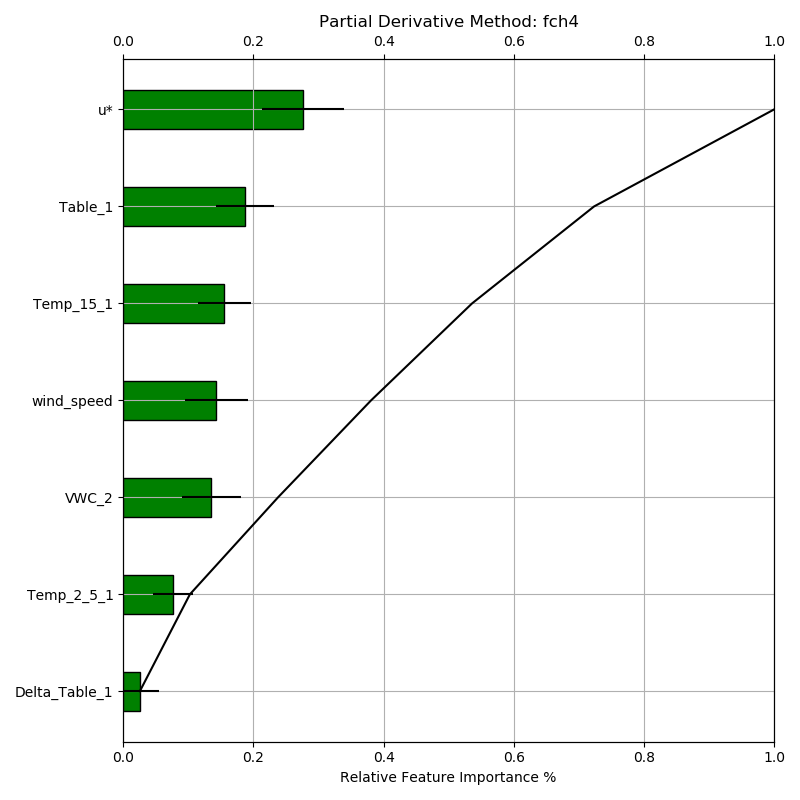

<IPython.core.display.Javascript object>


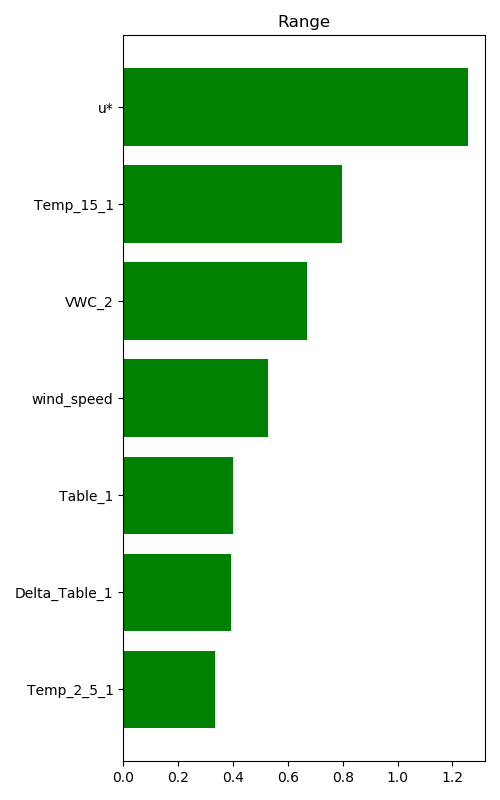

          Factor       Min       Max      Mean     Range         SSQ  \
0     Temp_2_5_1  0.525788  0.861256  0.696867  0.335468  871.314550   
1  Delta_Table_1 -0.648929 -0.254957 -0.485801  0.393973  450.505671   
2        Table_1 -0.311562  0.087889 -0.187721  0.399452   79.915082   
3     wind_speed  0.048507  0.575035  0.310208  0.526528  242.459249   
4          VWC_2 -0.798216 -0.126834 -0.461656  0.671382  489.047510   
5      Temp_15_1 -0.755883  0.041159 -0.352688  0.797043  426.739753   
6             u* -0.382650  0.873567  0.244131  1.256217  590.749911   

        Abs      SSQ%  
0  0.696867  0.276544  
1  0.485801  0.142984  
2  0.187721  0.025364  
3  0.310208  0.076953  
4  0.461656  0.155217  
5  0.352688  0.135441  
6  0.244131  0.187496  


In [117]:

# print(Records)
b = '15_0'
# a = '7_8'


try:
    Results = Results.loc[Results[a]>0].sort_values(a,ascending=True).reset_index()
except:
    pass

# print(a)
# print(Results[a],Results['RC: '+b],)
# print(Results.Factors.values[1:])
print(Results[a])
fig,ax=plt.subplots(figsize=(8,8))
ax.barh(Results.index,Results[a],xerr=Results[ase],
         height=.4,color='g',edgecolor='k')
# ax.barh(Results.index+.45,Results['RC: '+b],xerr=Results['SE: '+b],
#          height=.4,color='r',edgecolor='k')
ax2=ax.twiny()
ax2.plot(Results[a].cumsum(),Results.index,color='k')
# plt.barh(Results.index+.5,Results['RC: '+Min],xerr=Results['SE: '+Min],height=.5,color='r')
ax.set_yticks(Results.index)
ax.set_yticklabels(Results['Factors'].values)
# plt.xticks(rotation=90)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
ax.set_xlim(0,1)
ax2.set_xlim(0,1)
plt.tight_layout()
# plt.show()

plt.savefig('PAD_'+F+'_PrunedFactors.png')
# print(Results.shape[0])

Statistics['Abs']=np.abs(Statistics.Mean)
Statistics['SSQ%']=Statistics['SSQ']/Statistics['SSQ'].sum()
# print(Statistics.sort_values('Range'))
# try:
Statistics = Statistics.sort_values('Range').reset_index(drop=True)
# except:
#     pass
    
fig,ax=plt.subplots(figsize=(5,8))
ax.barh(Statistics.index,Statistics['Range'],
         color='g')
ax.set_yticks(Statistics.index)
ax.set_yticklabels(Statistics['Factor'].values)
ax.set_title('Range')
plt.tight_layout()

print(Statistics)

In [49]:
# print(Statistics.sort_values('Range'))
# plt.figure()
# plt.sca()

In [10]:
print('Carex: ',1e-3 * 16.04246 *3600*.052)
print('Peak: ',1e-3 * 16.04246 *3600*.03)
print('Peak: ',1e-3 * 16.04246 *3600*.015)
print('Mean: ',1e-3 * 16.04246 *3600*.012)
print('Intermediate: ',1e-3 * 16.04246 *3600*.018)
print('Shrub: ',1e-3 * 16.04246 *3600*.0004)

Carex:  3.0031485119999997
Peak:  1.7325856799999997
Peak:  0.8662928399999998
Mean:  0.6930342719999999
Intermediate:  1.039551408
Shrub:  0.0231011424


In [109]:
print('Early: ',1e-6*0.26*12.01*3600*24)
print('Vegetative: ',1e-6*-1.06*12.01*3600*24)
print('Reproduction: ',1e-6*-1.77*12.01*3600*24)
print('Sensence: ',1e-6*-0.78*12.01*3600*24)
print('Leaf Drop: ',1e-6*0.39*12.01*3600*24)



Early:  0.26979264000000003
Vegetative:  -1.09992384
Reproduction:  -1.8366652799999998
Sensence:  -0.80937792
Leaf Drop:  0.40468896
